In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import corner
import matplotlib as mpl
import struct
%matplotlib inline

In [2]:
def read_CIC_scalar(filename):
    f = open(filename, "rb")
    dumb = f.read(38)

    dumb = f.read(4)
    n_x = f.read(4)
    n_y = f.read(4)
    n_z = f.read(4)
    nodes = f.read(8)
    x0 = f.read(4)
    y0 = f.read(4)
    z0 = f.read(4)
    dx = f.read(4)
    dy = f.read(4)
    dz = f.read(4)
    dumb = f.read(4)

    n_x = (struct.unpack('i', n_x))[0]
    n_y = (struct.unpack('i', n_y))[0]
    n_z = (struct.unpack('i', n_z))[0]
    nodes = (struct.unpack('q', nodes))[0]
    dx = (struct.unpack('f', dx))[0]
    dy = (struct.unpack('f', dy))[0]
    dz = (struct.unpack('f', dz))[0]
    x0 = (struct.unpack('f', x0))[0]
    y0 = (struct.unpack('f', y0))[0]
    z0 = (struct.unpack('f', z0))[0]
    print n_x, n_y, n_z, nodes, dx, dy, dz

    total_nodes = n_x * n_y *n_z
    dumb = f.read(4)
    array_data = f.read(total_nodes*4)
    dumb = f.read(4)
    format_s = str(total_nodes)+'f'
    array_data = struct.unpack(format_s, array_data)
    f.close()
    array_data  = np.array(array_data)
    array_data.resize(n_z,n_y,n_x)
    array_data = array_data.transpose()
    return {'eigenval':array_data, 'delta_x':dx}


In [3]:
def read_vector_ascii(filename, boxsize=75000.0):
    data = np.loadtxt(filename)
    ii = data[:,0]
    n_side = len(set(ii))
    print(n_side)
    delta_size = boxsize/n_side
    new_data = np.ones((3,n_side, n_side, n_side))
    n = 0 
    for i in range(n_side):
        for j in range(n_side):
            for k in range(n_side):
                new_data[:,i,j,k] = data[n,3:]
                n= n+1
    return {'eigenvec':new_data, 'delta_x':delta_size}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot. 
    Source code: Adrian Price-Whelan https://gist.github.com/adrn/3993992
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-0.5)))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-2.0)))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-4.5)))
    levels = [one_sigma, two_sigma, three_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

In [5]:
def set_ticklabels(ax, size=18):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(size)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(size)
        label_y.set_family('serif')

In [6]:
def main_halos(snap_data):
    sorted_vmax = snap_data['vmax']
    sorted_vmax = np.sort(sorted_vmax)
    v_max_A = sorted_vmax[-1]
    v_max_B = sorted_vmax[-2]
    v_max_C = sorted_vmax[-3]
    ii = snap_data['vmax']==v_max_A
    jj = snap_data['vmax']==v_max_B
    #kk = snap_data['vmax']==v_max_C
    index = (ii | jj)
    #print sorted_vmax[-3::]
    main_halos_data = snap_data[index]
    if(main_halos_data['vmax'][0] < main_halos_data['vmax'][1]):
        tmp = main_halos_data[0].copy()
        main_halos_data[0] = main_halos_data[1].copy()
        main_halos_data[1] = tmp.copy()
    return main_halos_data

In [7]:
def satellite_halos(halo_data, halo_center):
    tmp_halo = halo_data.copy()
    radius = halo_center['vmax']/(10.0 * 100) * 1000 # in kpc/h
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = r < radius
    return halo_data[ii]

In [8]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
        
    return snap_data

In [9]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('bmag', 'f8'),
           ('delta_bmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [10]:
def get_best_plane(halo_data, halo_center, bright=True, all_points=False ,plotting=False, unit_vector=np.array([1.0,0.0,0.0])):
    
    if all_points==False:
        satellite_data = satellite_halos(halo_data, halo_center)
    else:
        satellite_data = halo_data.copy()
        
    if bright:
        ii = satellite_data['bmag'] < -9.0
        subset_satellite_data = satellite_data[ii]
    else:
        subset_satellite_data = satellite_data.copy()   

    
    #create vectors defining the planes
    n_vectors = 1000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)

    #create arrays storing distances to all planes
    n_satellites = len(subset_satellite_data)
    pos_satellites = np.zeros((n_satellites,3))

    col = list(['x','y','z'])
    for i in range(3):
        pos_satellites[:,i] = subset_satellite_data[col[i]] - halo_center[col[i]]
    pos_satellites = np.transpose(pos_satellites)
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    
    #i_min = np.argmax(delta_plane)
    
    #id_sorted = np.argsort(delta_plane)
    #n = len(id_sorted)
    #i_min = id_sorted[int(n/2)]
    #print i_min
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:])
    #print("plane vector", plane_vector)
    return plane_delta, plane_center, plane_vector, delta_plane, np.fabs(np.dot(plane_vector,unit_vector))

In [11]:
def inertiaTensor(x,y,z, unit_vector=np.array([1.0,0.0,0.0])):
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 

    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T

    TriaxParam = (ord_vals[2]**2  - ord_vals[1]**2)/(ord_vals[2]**2 - ord_vals[0]**2)
    AxisRatio = ord_vals[0]/ord_vals[2]
    return ord_vals, np.fabs(np.dot(ord_vects[2],unit_vector)), TriaxParam, AxisRatio, ord_vects

def inertiaTensorHalo(halo_data, halo_center, unit_vector=np.array([1.0,0.0,0.0]), n_samples=1, items_per_sample=1):
    x = halo_data['x'] - halo_center['x']
    y = halo_data['y'] - halo_center['y']
    z = halo_data['z'] - halo_center['z']
    if(n_samples==1):
        return inertiaTensor(x,y,z,unit_vector=unit_vector)
    else:
        tmp_triax = np.zeros(n_samples)
        tmp_axis_ratio = np.zeros(n_samples)
        for i in range(n_samples):
            x_tmp = np.random.choice(x, items_per_sample)
            y_tmp = np.random.choice(y, items_per_sample)
            z_tmp = np.random.choice(z, items_per_sample)
            dd, dd, tmp_triax[i], tmp_axis_ratio[i], vv = inertiaTensor(x_tmp,y_tmp,z_tmp,unit_vector=unit_vector)
        return dd, dd, np.median(tmp_triax), np.median(tmp_axis_ratio),vv

In [12]:
def gen_random_sphere(n_points):
    """
    Sets of points in the sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [13]:
def sample_cos_ABX(N_points_A=21, N_points_B=32):
    """
    Sample the tensor alignment between two spheres sampled with
    different number of points.
    """
    x, y, z = gen_random_sphere(N_points_A)
    eigenval, _ , triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_A = eigenvec[2]/sum(eigenvec[2]**2)

    x, y, z = gen_random_sphere(N_points_B)
    eigenval, _, triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_B = eigenvec[2]/sum(eigenvec[2]**2)

    cos_AB = abs(sum(main_eigenvec_A * main_eigenvec_B))
    cos_AX = abs(main_eigenvec_A[0])
    cos_BX = abs(main_eigenvec_B[0])
    return cos_AB, cos_AX, cos_BX

In [14]:
def sample_pairs(list_N_points_A=list([10]), list_N_points_B=list([20])):
    """
    Sample lists of pairs and get the median of their alignments.
    """
    M = len(list_N_points_A)
    cos_AB_array = np.zeros(M)
    cos_AX_array = np.zeros(M)
    cos_BX_array = np.zeros(M)

    for i in range(M):
        cos_AB_array[i], cos_AX_array[i], cos_BX_array[i] = \
            sample_cos_ABX(N_points_A = list_N_points_A[i], N_points_B = list_N_points_B[i])
        
    cos_AB_array.sort()
    cos_AX_array.sort()
    cos_BX_array.sort()
    return np.median(cos_AB_array), np.median(cos_AX_array), np.median(cos_BX_array)

In [15]:
def monte_carlo_sample_pairs(n_monte_carlo=1000, list_N_points_A=list([10]), list_N_points_B=list([20])):
    median_AB = np.zeros(n_monte_carlo)
    median_AX = np.zeros(n_monte_carlo)
    median_BX = np.zeros(n_monte_carlo)

    for i in range(n_monte_carlo):
        m_AB, m_AX, m_BX = sample_pairs(list_N_points_A=list_N_points_A, list_N_points_B=list_N_points_B)
        median_AB[i] = m_AB
        median_AX[i] = m_AX
        median_BX[i] = m_BX
    return median_AB, median_AX, median_BX


In [16]:
def get_environment(eigenv_1, eigenv_2, eigenv_3, eigenvec_3, pos_x=0.0, pos_y=0.0, pos_z=0.0):
    delta_x = eigenv_1['delta_x']
    i = int(pos_x//delta_x)
    j = int(pos_y//delta_x)
    k = int(pos_z//delta_x)
    norma = np.sqrt(np.sum(eigenvec_3['eigenvec'][:,i,j,k]**2))
    #print(i,j,k, norma)
    return {'eigen_1': eigenv_1['eigenval'][i,j,k],
                'eigen_2': eigenv_2['eigenval'][i,j,k],
                'eigen_3': eigenv_3['eigenval'][i,j,k],
                'eigenvec_3': eigenvec_3['eigenvec'][:,i,j,k]/norma}

In [17]:
eigen_1 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_1")
eigen_2 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_2")
eigen_3 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_3")
eigenv_1 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_1.dat")
eigenv_2 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_2.dat")
eigenv_3 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_3.dat")


FA = (eigen_1['eigenval']-eigen_3['eigenval'])**2  + (eigen_2['eigenval']-eigen_3['eigenval'])**2\
    + (eigen_1['eigenval']-eigen_2['eigenval'])**2 
FA = FA/(eigen_1['eigenval']**2 + eigen_2['eigenval']**2 + eigen_3['eigenval']**2)
FA = np.sqrt(FA)/np.sqrt(3.0)
web_env = get_environment(eigen_1, eigen_2, eigen_3, eigenv_1, pos_x=3450.0, pos_y=4900.0, pos_z=74999.0)
print(web_env['eigenvec_3'])
np.sqrt(np.sum(web_env['eigenvec_3']**2))
print(web_env['eigen_1'], web_env['eigen_2'], web_env['eigen_3'])
print(eigenv_1['eigenvec'][:,1,20,26])


76 76 76 438976 986.842102051 986.842102051 986.842102051
76 76 76 438976 986.842102051 986.842102051 986.842102051
76 76 76 438976 986.842102051 986.842102051 986.842102051
76
76
76
[-0.61421523 -0.32393712  0.71958627]
(-0.11574846506118774, -0.5262758731842041, -0.7431299090385437)
[ 0.702816 -0.708913  0.059099]


In [18]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

r_LG = np.zeros(3)
r_LG[0] = MW_data['x'][0] - M31_data['x'][0]
r_LG[1] = MW_data['y'][0] - M31_data['y'][0]
r_LG[2] = MW_data['z'][0] - M31_data['z'][0]
r_LG = r_LG/np.sqrt(np.sum(r_LG**2))

n_iter = 100
n_MW_iter = np.ones(n_iter)
MW_plane_delta_iter = np.ones(n_iter)
MW_dot_product_iter = np.ones(n_iter)
n_M31_iter = np.ones(n_iter)
M31_plane_delta_iter = np.ones(n_iter)
M31_dot_product_iter = np.ones(n_iter)

tmp_MW_bmag = np.zeros(len(MW_data))
tmp_M31_bmag = np.zeros(len(M31_data))

for i in range(n_iter):
    n = len(MW_data)
    for j in range(n):
        tmp_MW_bmag[j] = np.random.normal(loc=MW_data['bmag'][j], scale=MW_data['delta_bmag'][j])
        
    n = len(M31_data)
    for j in range(n):
        tmp_M31_bmag[j] = np.random.normal(loc=M31_data['bmag'][j], scale=M31_data['delta_bmag'][j])
    
    ii = tmp_MW_bmag<-9.0
    n_MW = len(MW_data[ii])
    MW_plane_delta, MW_plane_center, MW_plane_vector,_,_ = get_best_plane(MW_data, MW_data[0], all_points=True)
    _,dot_product_r_MW, triax_MW, axratio_MW,_ = \
        inertiaTensorHalo(MW_data[ii], MW_data[0], unit_vector=r_LG)
    
    ii = tmp_M31_bmag<-9.0
    n_M31 = len(M31_data[ii])
    M31_plane_delta, M31_plane_center, M31_plane_vector,_,_ = get_best_plane(M31_data, M31_data[0], all_points=True)
    _,dot_product_r_M31, triax_M31, axratio_M31,_ = \
        inertiaTensorHalo(M31_data[ii], M31_data[0], unit_vector=r_LG)
    
    
    n_MW_iter[i] = n_MW
    MW_plane_delta_iter[i] = MW_plane_delta
    MW_dot_product_iter[i] = dot_product_r_MW
    n_M31_iter[i] = n_M31
    M31_plane_delta_iter[i] = M31_plane_delta
    M31_dot_product_iter[i] = dot_product_r_M31

print n_MW_iter.mean(), n_MW_iter.std()
print MW_plane_delta_iter.mean(),MW_plane_delta_iter.std()
print n_M31_iter.mean(), n_M31_iter.std()
print M31_plane_delta_iter.mean(), M31_plane_delta_iter.std()

10.86 0.860464990572
50.5402063233 0.253163928833
20.98 1.21638809596
127.602664669 0.999070870962


In [19]:
#plt.scatter(M31_dot_product_iter, MW_dot_product_iter)
M31_dot_product = np.percentile(M31_dot_product_iter, [16,50,84])
MW_dot_product = np.percentile(MW_dot_product_iter, [16,50,84])
print MW_dot_product
print M31_dot_product


[ 0.8720349   0.88514944  0.90190826]
[ 0.98696817  0.99721509  0.99989537]


In [20]:
n_pairs = 53
v_circ_A = np.zeros(n_pairs)
v_circ_B = np.zeros(n_pairs)
v_circ_C = np.zeros(n_pairs)
distance_AB = np.zeros(n_pairs)
velocity_AB = np.zeros(n_pairs)
n_bright = np.zeros(n_pairs)
n_total = np.zeros(n_pairs)
n_bright_A = np.zeros(n_pairs)
n_bright_B = np.zeros(n_pairs)
n_dark_A  = np.zeros(n_pairs)
n_dark_B = np.zeros(n_pairs)
distance_radius_ratio = np.zeros(n_pairs)
triax_bright_A = np.zeros(n_pairs)
triax_bright_B = np.zeros(n_pairs)
axratio_bright_A = np.zeros(n_pairs)
axratio_bright_B = np.zeros(n_pairs)
triax_dark_A = np.zeros(n_pairs)
triax_dark_B = np.zeros(n_pairs)
axratio_dark_A = np.zeros(n_pairs)
axratio_dark_B = np.zeros(n_pairs)
axratio_dark_sampled_A = np.zeros(n_pairs)
axratio_dark_sampled_B = np.zeros(n_pairs)
r_AB = np.zeros((n_pairs,3))
dot_product_bright_AB = np.zeros(n_pairs)
dot_product_r_bright_A = np.zeros(n_pairs)
dot_product_r_bright_B = np.zeros(n_pairs)
dot_product_r_dark_A = np.zeros(n_pairs)
dot_product_r_dark_B = np.zeros(n_pairs)
dot_product_plane_bright_A = np.zeros(n_pairs)
dot_product_plane_bright_B = np.zeros(n_pairs)
dot_product_plane_dark_A = np.zeros(n_pairs)
dot_product_plane_dark_B = np.zeros(n_pairs)
plane_width_bright_A = np.zeros(n_pairs)
plane_width_dark_A = np.zeros(n_pairs)
plane_width_bright_B = np.zeros(n_pairs)
plane_width_dark_B = np.zeros(n_pairs)
dot_product_shape_A = np.zeros(n_pairs)
dot_product_shape_B = np.zeros(n_pairs)
dot_product_r_tweb_e3 = np.zeros(n_pairs)
dot_product_tweb_shape_bright_A = np.zeros(n_pairs)
dot_product_tweb_shape_bright_B = np.zeros(n_pairs)
dot_product_tweb_shape_dark_A = np.zeros(n_pairs)
dot_product_tweb_shape_dark_B = np.zeros(n_pairs)
tweb_environment = dict()
delta_env = np.zeros(n_pairs)
for i in range(n_pairs):
    filename = "../data/dm_selected/Illustris_group_{}.dat".format(i)
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    satellite_data_A = satellite_halos(data, main_h_data[0])
    satellite_data_B = satellite_halos(data, main_h_data[1])
    
    
    v_circ_A[i] = main_h_data['vmax'][0]
    v_circ_B[i] = main_h_data['vmax'][1]
    radius_A = main_h_data['vmax'][0]/(10.0 * 100) * 1000 # in kpc/h
    radius_B = main_h_data['vmax'][1]/(10.0 * 100) * 1000 # in kpc/h
    
    r_AB[i][0] = main_h_data['x'][1] - main_h_data['x'][0]
    r_AB[i][1] = main_h_data['y'][1] - main_h_data['y'][0]
    r_AB[i][2] = main_h_data['z'][1] - main_h_data['z'][0]
    r_AB[i] = r_AB[i]/np.sqrt(np.sum(r_AB[i]**2))
    #print r_AB[i]
    
    distance_AB[i] =  np.sqrt((main_h_data['x'][0] - main_h_data['x'][1])**2 \
                    + (main_h_data['y'][0] - main_h_data['y'][1])**2 \
                    + (main_h_data['z'][0] - main_h_data['z'][1])**2)
    velocity_AB[i] = np.sqrt((main_h_data['vx'][0] - main_h_data['vx'][1])**2 \
                    + (main_h_data['vy'][0] - main_h_data['vy'][1])**2 \
                    + (main_h_data['vz'][0] - main_h_data['vz'][1])**2)
    
    # tweb environment
    web_env[i] = get_environment(eigen_1, eigen_2, eigen_3, eigenv_3,\
                              pos_x=main_h_data['x'][0],\
                              pos_y=main_h_data['y'][0],\
                              pos_z=main_h_data['z'][0])
    delta_env[i] = web_env[i]['eigen_1'] + web_env[i]['eigen_2'] + web_env[i]['eigen_3']
    
    #best planes
    plane_width_bright_A[i], _, _ , _, dot_product_plane_bright_A[i] = \
        get_best_plane(data, main_h_data[0], bright=True, unit_vector=r_AB[i])
    plane_width_dark_A[i], _, _ , _ , dot_product_plane_dark_A[i] = \
        get_best_plane(data, main_h_data[0], bright=False, unit_vector=r_AB[i])
    plane_width_bright_B[i], _, _ , _, dot_product_plane_bright_B[i] = \
        get_best_plane(data, main_h_data[1], bright=True, unit_vector=r_AB[i])
    plane_width_dark_B[i], _, _ , _, dot_product_plane_dark_B[i] = \
        get_best_plane(data, main_h_data[1], bright=False, unit_vector=r_AB[i])

    # alignments with the vector joining the two halos    
    ii = satellite_data_A['bmag'] < 0.0
    n_bright_A[i] = len(satellite_data_A[ii])
    n_dark_A[i] = len(satellite_data_A)
    _,dot_product_r_bright_A[i],triax_bright_A[i],axratio_bright_A[i], unit_vectors_bright_A = \
        inertiaTensorHalo(satellite_data_A[ii], main_h_data[0], unit_vector=r_AB[i])
        
    _,dot_product_r_dark_A[i],triax_dark_A[i],axratio_dark_A[i], unit_vectors_dark_A = \
        inertiaTensorHalo(satellite_data_A, main_h_data[0], unit_vector=r_AB[i])
        
    _,_,_,axratio_dark_sampled_A[i], _ = \
        inertiaTensorHalo(satellite_data_A, main_h_data[0], unit_vector=r_AB[i], 
                          n_samples=1000, items_per_sample=int(n_bright_A[i]))
    
    dot_product_shape_A[i] = np.fabs(np.dot(unit_vectors_bright_A[0], unit_vectors_dark_A[0]))
    dot_product_tweb_shape_bright_A[i] = np.fabs(np.dot(unit_vectors_bright_A[0], web_env[i]['eigenvec_3']))
    dot_product_tweb_shape_dark_A[i] = np.fabs(np.dot(unit_vectors_dark_A[0], web_env[i]['eigenvec_3']))

    
    ii = satellite_data_B['bmag'] < 0.0
    n_bright_B[i] = len(satellite_data_B[ii])
    n_dark_B[i] = len(satellite_data_B)
    _,dot_product_r_bright_B[i],triax_bright_B[i],axratio_bright_B[i], unit_vectors_bright_B = \
        inertiaTensorHalo(satellite_data_B[ii], main_h_data[1], unit_vector=r_AB[i])
    
    _,dot_product_r_dark_B[i],triax_dark_B[i],axratio_dark_B[i], unit_vectors_dark_B = \
        inertiaTensorHalo(satellite_data_B, main_h_data[1], unit_vector=r_AB[i])
    
    _,_,_,axratio_dark_sampled_B[i], _ = \
        inertiaTensorHalo(satellite_data_B, main_h_data[1], unit_vector=r_AB[i], 
                          n_samples=1000, items_per_sample=int(n_bright_B[i]))
                          
    dot_product_shape_B[i] = np.fabs(np.dot(unit_vectors_bright_B[0], unit_vectors_dark_B[0]))
    dot_product_tweb_shape_bright_B[i] = np.fabs(np.dot(unit_vectors_bright_B[0], web_env[i]['eigenvec_3']))
    dot_product_tweb_shape_dark_B[i] = np.fabs(np.dot(unit_vectors_dark_B[0], web_env[i]['eigenvec_3']))

    
    dot_product_bright_AB[i] = np.fabs(np.dot(unit_vectors_bright_A[0], unit_vectors_bright_B[0]))
    
    #print("web end", web_env[i])
    dot_product_r_tweb_e3[i] = np.fabs(np.dot(r_AB[i], web_env[i]['eigenvec_3']))
    
    n_total[i] = len(data)
    ii = data['bmag'] < 0
    n_bright[i] = len(data[ii])
    #if((distance_AB[i] > 700.0) & (distance_AB[i]<1400) & (velocity_AB[i]>100.0)):
    #    print('halo file {}'.format(i))
    distance_radius_ratio[i] = distance_AB[i]/(radius_A + radius_B)
    if(distance_AB[i] < (radius_A + radius_B)):
        print('halo file {} are touching'.format(i))
        print('distance {} : radius_sum {}'.format(distance_AB[i], radius_A+radius_B))

halo file 0 are touching
distance 132.329152767 : radius_sum 486.785492
halo file 6 are touching
distance 403.063577143 : radius_sum 421.533783
halo file 31 are touching
distance 170.300808893 : radius_sum 436.534836
halo file 51 are touching
distance 119.860027673 : radius_sum 387.000824


In [21]:
ifull = (distance_AB > 0) & (distance_radius_ratio > 1.0) & (n_bright_A > 4) & (n_bright_B > 4)
lgsample = (distance_AB > 700.0) & (distance_AB<1400) & (velocity_AB>100) & (distance_radius_ratio > 1.0) \
           & (n_bright_A > 4) & (n_bright_B > 4)

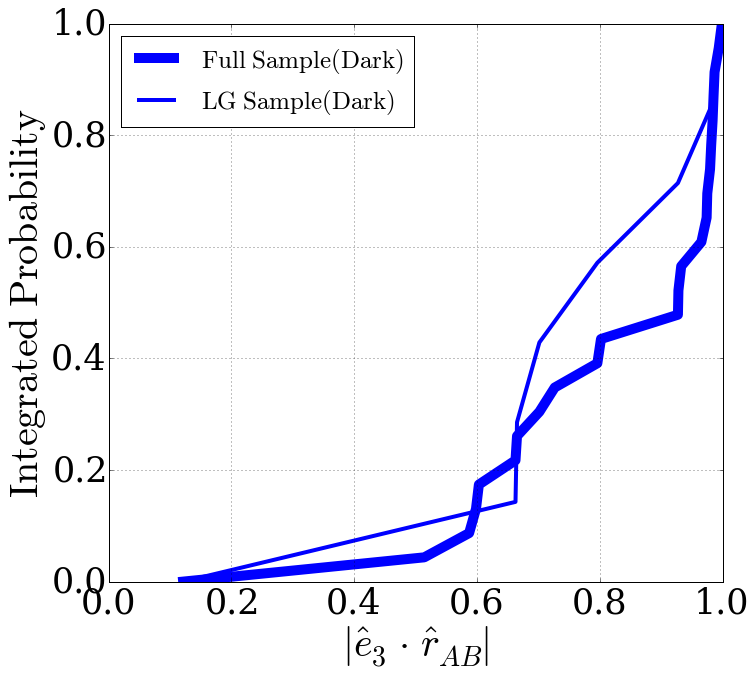

In [22]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

y = dot_product_r_tweb_e3[ifull]
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')


y = dot_product_r_tweb_e3[lgsample]
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')



ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{e}_3\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/r_tweb_e3_alignment.pdf', bbox_inches='tight')

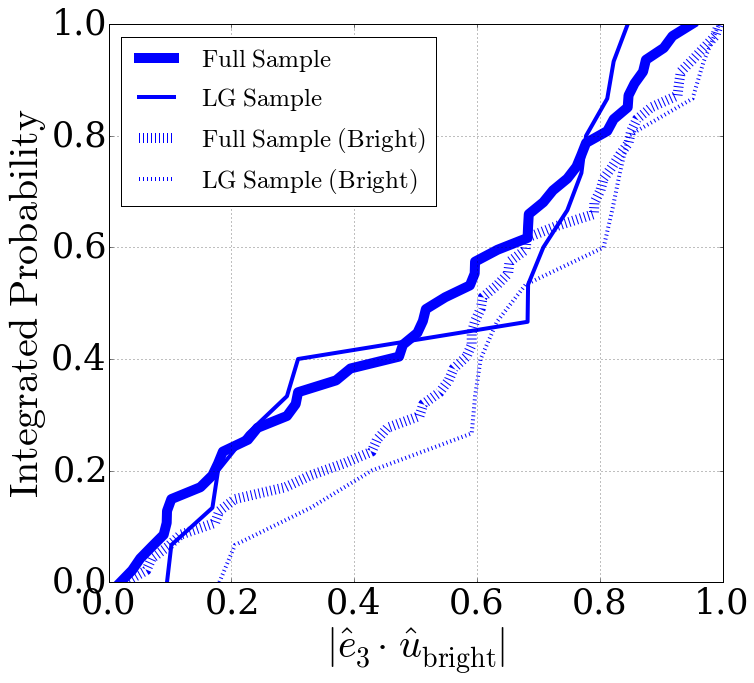

In [23]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = np.concatenate((dot_product_tweb_shape_dark_A[ifull],dot_product_tweb_shape_dark_B[ifull]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample}$',color='b', linewidth=10, linestyle='-')


axratio = np.concatenate((dot_product_tweb_shape_dark_A[lgsample],dot_product_tweb_shape_dark_B[lgsample]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample}$',color='b', linewidth=4, linestyle='-')

axratio = np.concatenate((dot_product_tweb_shape_bright_A[ifull],dot_product_tweb_shape_bright_B[ifull]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Bright)}$',color='b', linewidth=10, linestyle=':')


axratio = np.concatenate((dot_product_tweb_shape_bright_A[lgsample],dot_product_tweb_shape_bright_B[lgsample]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample\ (Bright)}$',color='b', linewidth=4, linestyle=':')



ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{e}_{3}\cdot\ \hat{u}_{\rm{bright}}|$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/align_bright_tweb_all.pdf', bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


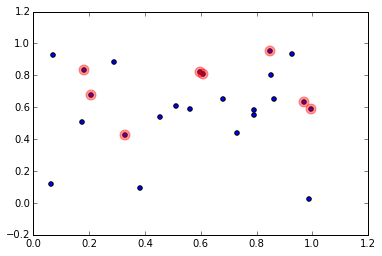

In [24]:
plt.scatter(dot_product_tweb_shape_bright_A[ifull],dot_product_tweb_shape_bright_B[ifull])
plt.scatter(dot_product_tweb_shape_bright_A[lgsample],dot_product_tweb_shape_bright_B[lgsample], color='red', alpha=0.4,s=100)


In [25]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

MW_plane_delta, MW_plane_center, MW_plane_vector,_,_ = get_best_plane(MW_data, MW_data[0], all_points=True)
M31_plane_delta, M31_plane_center, M31_plane_vector,_,_ = get_best_plane(M31_data, M31_data[0], all_points=True)


ii = MW_data['bmag']<-9.0
n_MW = len(MW_data[ii])
ii = M31_data['bmag']<-9.0
n_M31 = len(M31_data[ii])

r_LG = np.zeros(3)
r_LG[0] = MW_data['x'][0] - M31_data['x'][0]
r_LG[1] = MW_data['y'][0] - M31_data['y'][0]
r_LG[2] = MW_data['z'][0] - M31_data['z'][0]
r_LG = r_LG/np.sqrt(np.sum(r_LG**2))


ii = MW_data['bmag'] < -9.0
_,dot_product_r_MW, triax_MW, axratio_MW, vectors_MW= \
        inertiaTensorHalo(MW_data[ii], MW_data[0], unit_vector=r_LG)

ii = M31_data['bmag'] < -9.0
_,dot_product_r_M31, triax_M31, axratio_M31, vectors_M31 = \
        inertiaTensorHalo(M31_data[ii], M31_data[0], unit_vector=r_LG)

print n_MW, n_M31
print(MW_plane_delta, M31_plane_delta)
print(dot_product_r_MW, dot_product_r_M31)

11 21
(50.546656789943221, 129.38533965371158)
(0.88514944420090813, 0.9999258333543255)


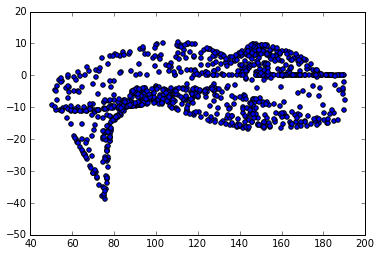

In [26]:
MW_plane_delta, MW_plane_center, MW_plane_vector, MW_widths,_ = get_best_plane(MW_data, MW_data[0], all_points=True, plotting=True)

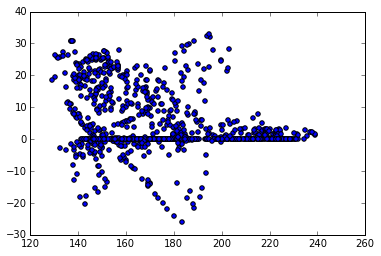

In [27]:
M31_plane_delta, M31_plane_center, M31_plane_vector, M31_widths,_ = get_best_plane(M31_data, M31_data[0], all_points=True, plotting=True)

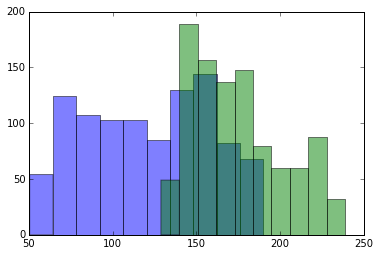

In [28]:
a= plt.hist(MW_widths, alpha=0.5)
a= plt.hist(M31_widths, alpha=0.5)

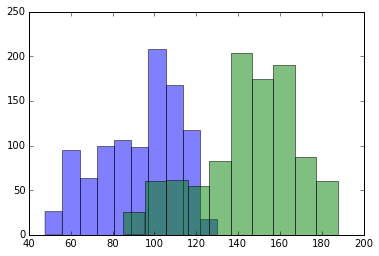

In [29]:
i = 51
filename = "../data/dm_selected/Illustris_group_{}.dat".format(i)
data = load_snapshot(filename)
main_h_data = main_halos(data)
_, _, _ , p_widths_bright,_ =get_best_plane(data, main_h_data[0], bright=True)
_, _, _ , p_widths_dark,_ =get_best_plane(data, main_h_data[0], bright=False)
a= plt.hist(p_widths_bright, alpha=0.5)
a= plt.hist(p_widths_dark, alpha=0.5)

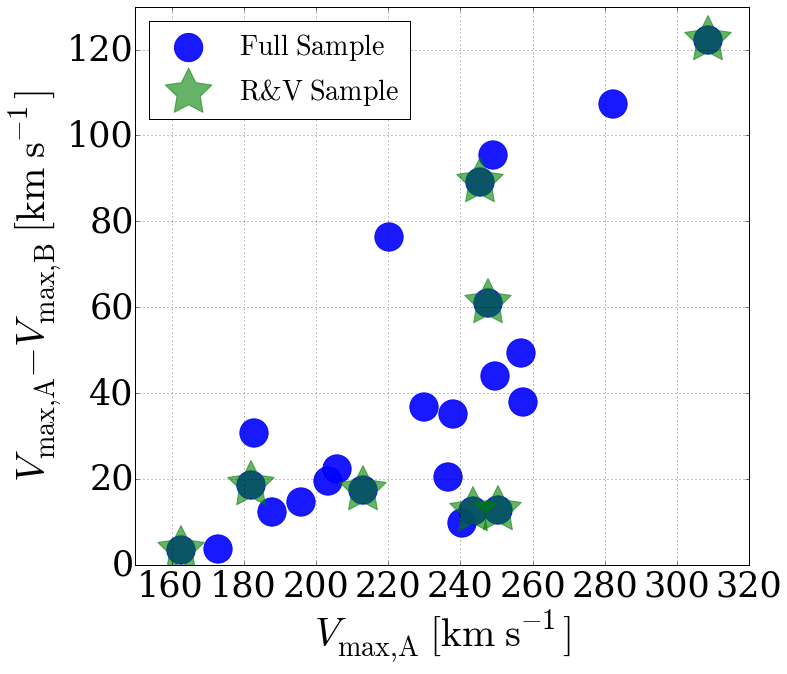

In [30]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(v_circ_A[ifull], v_circ_A[ifull] - v_circ_B[ifull], label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(v_circ_A[lgsample], v_circ_A[lgsample] - v_circ_B[lgsample], label='$\mathrm{R&V\ Sample}$',
            s=2400,alpha=0.6,color='green', marker=(5,1))

ax.grid(True)

ax.set_xlim([150,320])
ax.set_ylim([0.0,130])

plt.xlabel(r'$V_{\rm{max,A}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.ylabel(r'$V_{\rm{max,A}} - V_{\rm{max,B}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_circ_pairs.pdf', bbox_inches='tight')

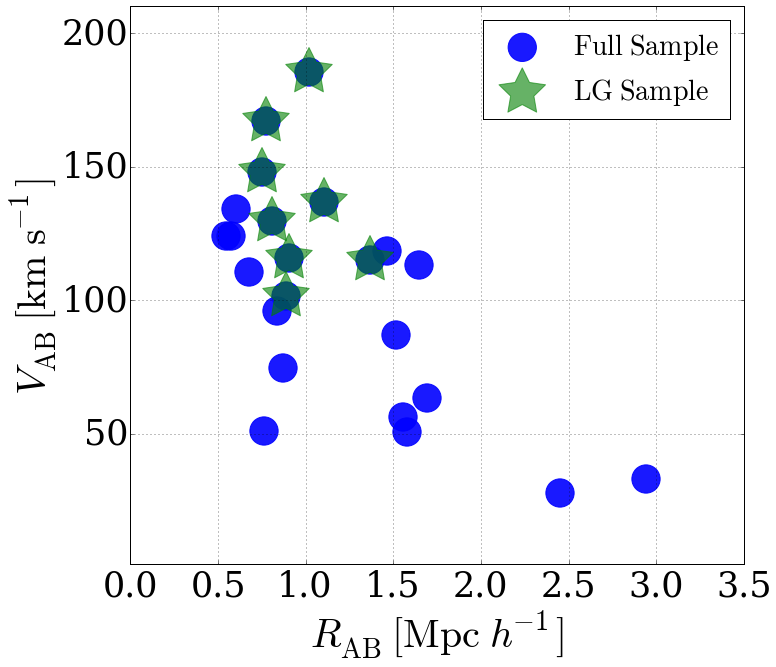

In [31]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(distance_AB[ifull]/1000.0, velocity_AB[ifull], label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(distance_AB[lgsample]/1000, velocity_AB[lgsample], label='$\mathrm{LG\ Sample}$',
            s=2400,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0.0,3.5])
ax.set_ylim([1,210])
ax.grid(True)


plt.xlabel(r'$R_{\rm{AB}} \ [{\rm{Mpc}}\ h^{-1}]$', size=40)
plt.ylabel(r'$V_{\rm{AB}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=1, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_r_pairs.pdf', bbox_inches='tight')


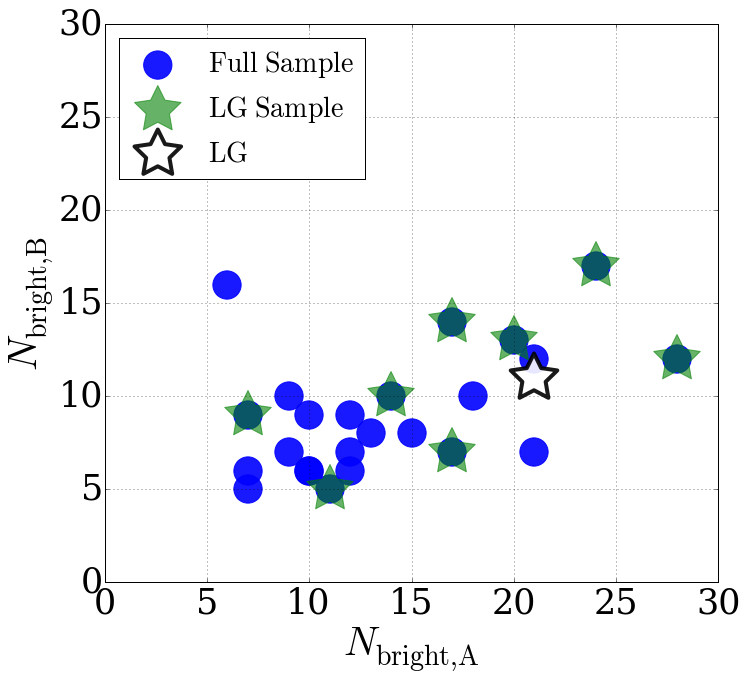

In [32]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_bright_A[ifull], n_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(n_bright_A[lgsample], n_bright_B[lgsample], label='$\mathrm{LG\ Sample}$',
            s=2400,alpha=0.6,color='green', marker=(5,1))

plt.scatter(n_M31, n_MW, 
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)

ax.set_xlim([0,30])
ax.set_ylim([0,30])
ax.grid(True)


plt.xlabel(r'$N_{\rm{bright,A}}$', size=40)
plt.ylabel(r'$N_{\rm{bright,B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/n_structure.pdf', bbox_inches='tight')

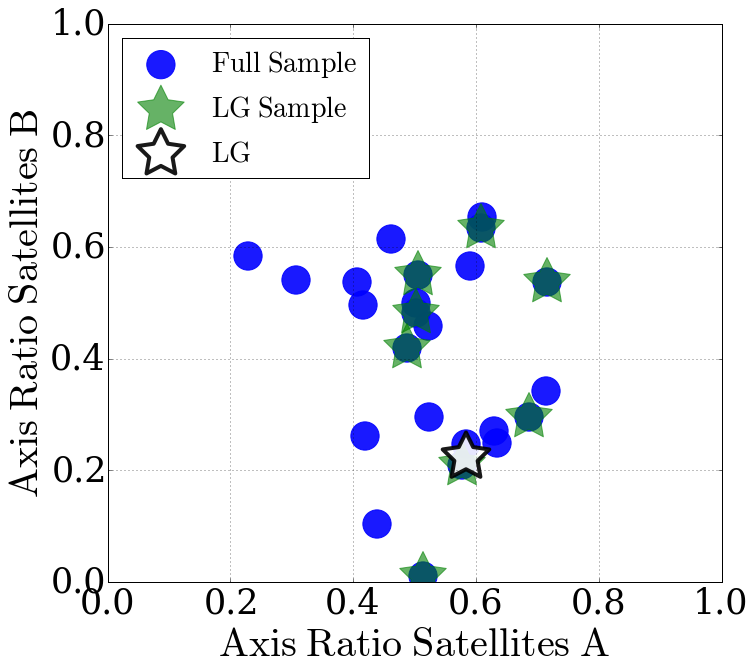

In [33]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(axratio_bright_A[ifull], axratio_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(axratio_bright_A[lgsample], axratio_bright_B[lgsample], label='$\mathrm{LG\ Sample}$',
            s=2400,alpha=0.6,color='green', marker=(5,1))

plt.scatter(axratio_M31, axratio_MW, 
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Axis\ Ratio\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Axis\ Ratio\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/axratio_bright.pdf', bbox_inches='tight')

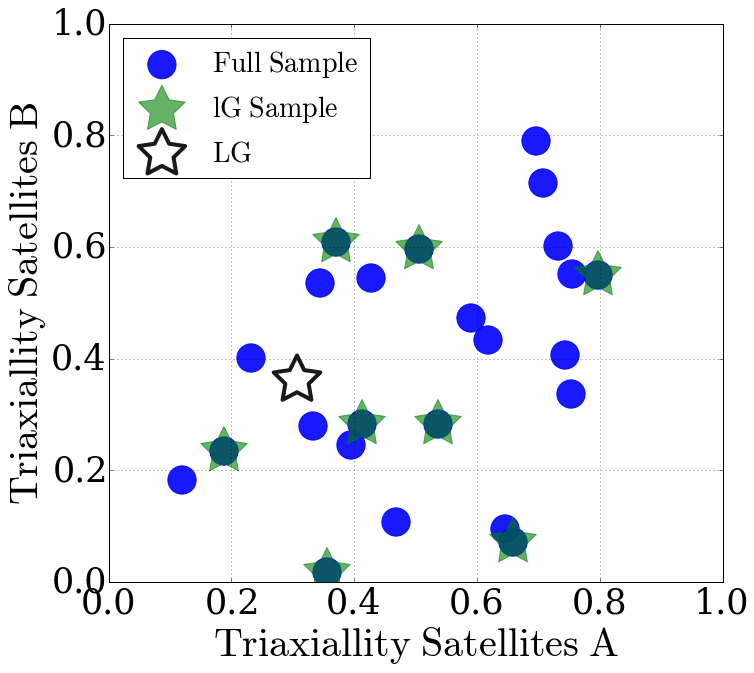

In [34]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(triax_bright_A[ifull], triax_bright_B[ifull],label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(triax_bright_A[lgsample], triax_bright_B[lgsample], label='$\mathrm{lG\ Sample}$',
            s=2400,alpha=0.6,color='g', marker=(5,1))

plt.scatter(triax_M31, triax_MW,
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Triaxiallity\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Triaxiallity\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/triax_bright.pdf', bbox_inches='tight')

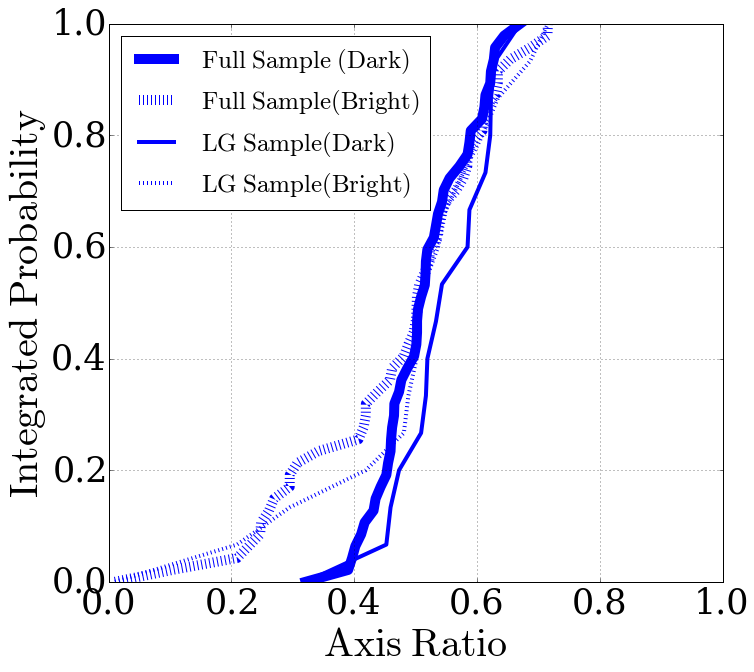

In [35]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = np.concatenate((axratio_dark_sampled_A[ifull], axratio_dark_sampled_B[ifull]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Dark)}$',color='b', linewidth=10, linestyle='-')

axratio = np.concatenate((axratio_bright_A[ifull], axratio_bright_B[ifull]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')

axratio = np.concatenate((axratio_dark_sampled_A[lgsample], axratio_dark_sampled_B[lgsample]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')

axratio = np.concatenate((axratio_bright_A[lgsample], axratio_bright_B[lgsample]), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample (Bright)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Axis\ Ratio}}$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/axratio_dark_bright.pdf', bbox_inches='tight')

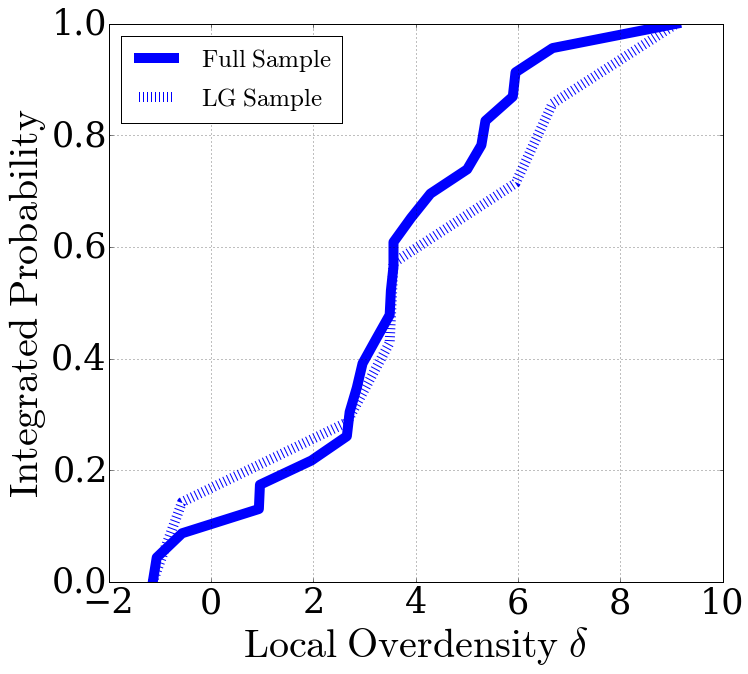

In [36]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


y = delta_env[ifull]
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample}$',color='b', linewidth=10, linestyle='-')


y = delta_env[lgsample]
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample}$',color='b', linewidth=10, linestyle=':')


ax.set_xlim([-2,10])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${{\rm{Local\ Overdensity}}\ \delta}$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/delta_env.pdf', bbox_inches='tight')

(0, 1)

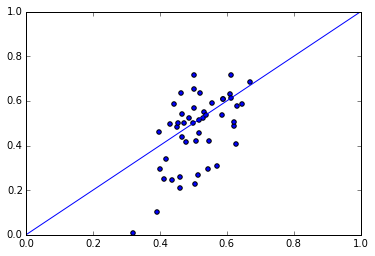

In [37]:
x = np.concatenate((axratio_dark_sampled_A[ifull], axratio_dark_sampled_B[ifull]), axis=0)
y = np.concatenate((axratio_bright_A[ifull], axratio_bright_B[ifull]), axis=0)
plt.scatter(x,y)
plt.plot(np.linspace(0,1,100), np.linspace(0,1.0,100))
plt.xlim(0,1)
plt.ylim(0,1)

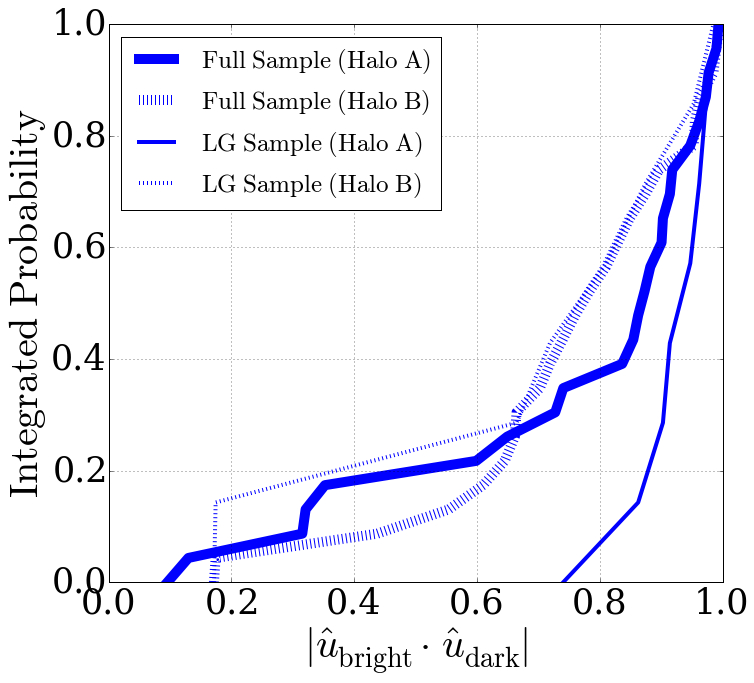

In [38]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = dot_product_shape_A[ifull]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Halo\ A)}$',color='b', linewidth=10, linestyle='-')


axratio = dot_product_shape_B[ifull]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Halo\ B)}$',color='b', linewidth=10, linestyle=':')



axratio = dot_product_shape_A[lgsample]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample\ (Halo\ A)}$',color='b', linewidth=4, linestyle='-')


axratio = dot_product_shape_B[lgsample]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample\ (Halo\ B)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}_{\rm{bright}}\cdot\ \hat{u}_{\rm{dark}}|$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/align_dark_bright.pdf', bbox_inches='tight')

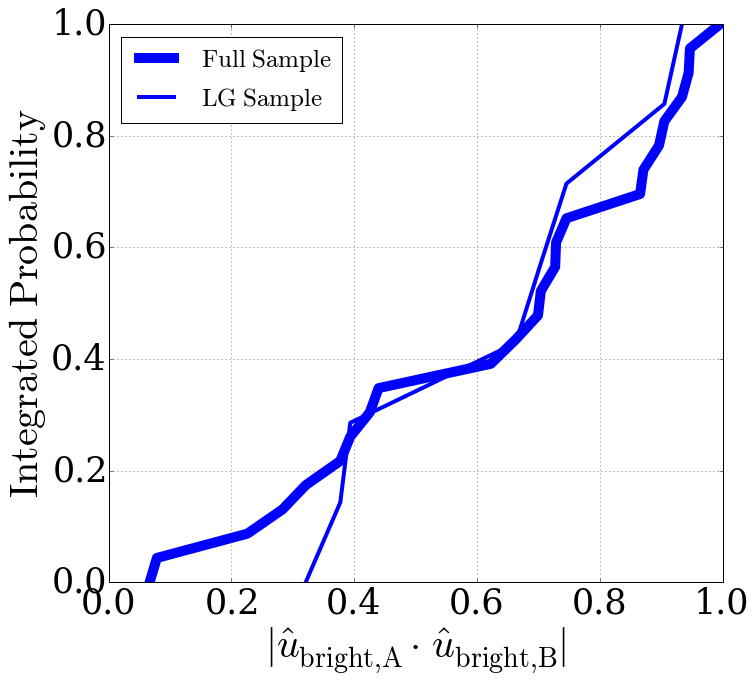

In [39]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = dot_product_bright_AB[ifull]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ }$',color='b', linewidth=10, linestyle='-')



axratio = dot_product_bright_AB[lgsample]
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{LG\ Sample\ }$',color='b', linewidth=4, linestyle='-')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}_{\rm{bright,A}}\cdot\ \hat{u}_{\rm{bright,B}}|$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/align_bright_AB.pdf', bbox_inches='tight')

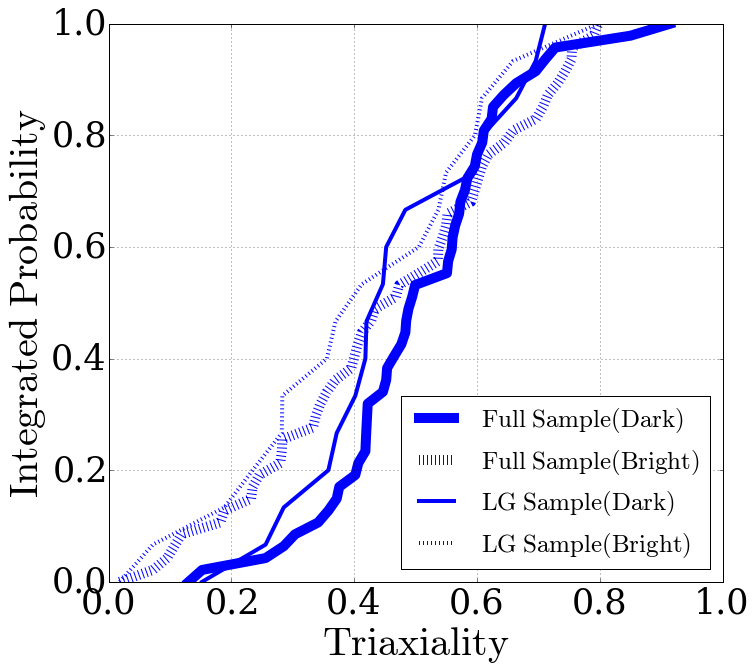

In [40]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


y = np.concatenate((triax_dark_A[ifull], triax_dark_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((triax_bright_A[ifull], triax_bright_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')

y = np.concatenate((triax_dark_A[lgsample], triax_dark_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')

y = np.concatenate((triax_bright_A[lgsample], triax_bright_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Bright)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Triaxiality}}$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=4, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/triax_dark_bright.pdf', bbox_inches='tight')

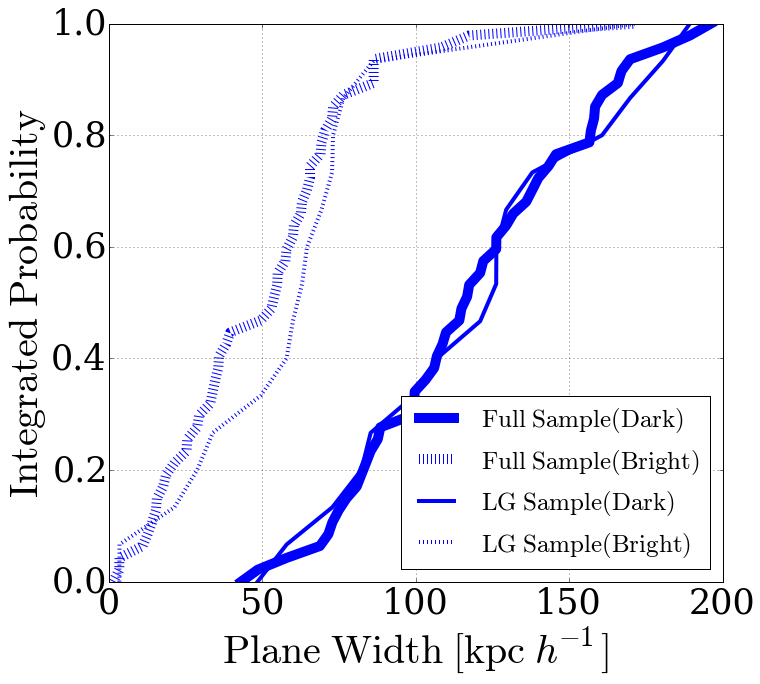

In [41]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

y = np.concatenate((plane_width_dark_A[ifull], plane_width_dark_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((plane_width_bright_A[ifull], plane_width_bright_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')

y = np.concatenate((plane_width_dark_A[lgsample], plane_width_dark_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')

y = np.concatenate((plane_width_bright_A[lgsample], plane_width_bright_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Bright)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,200])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'${{\rm{Plane\ Width}\ }[{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=4, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/plane_width.pdf', bbox_inches='tight')

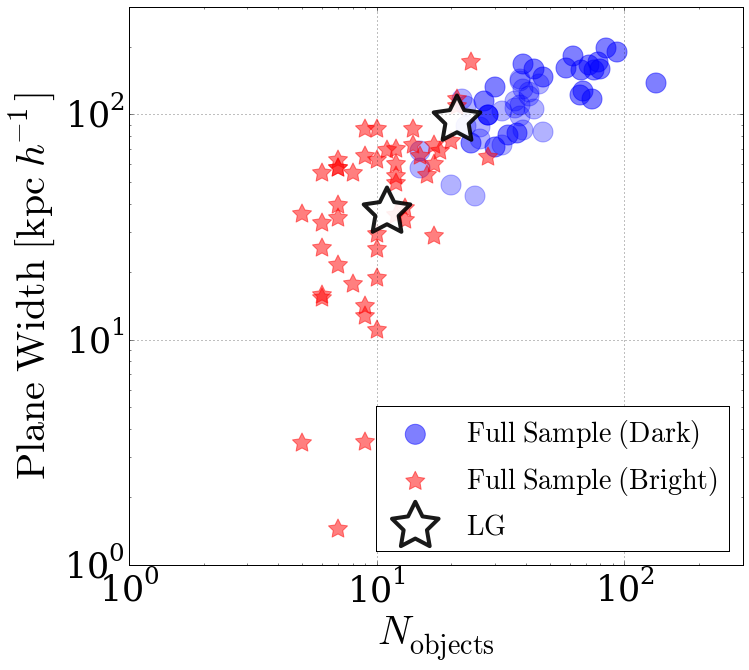

In [42]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_dark_A[ifull], plane_width_dark_A[ifull],
                label='$\mathrm{Full\ Sample\ (Dark)}$',s=400,alpha=0.5,color='b')
plt.scatter(n_dark_B[ifull], plane_width_dark_B[ifull],s=400,alpha=0.3,color='b')

plt.scatter(n_bright_A[ifull], plane_width_bright_A[ifull],
                label='$\mathrm{Full\ Sample\ (Bright)}$',s=400,alpha=0.5,color='red', marker=(5,1))
plt.scatter(n_bright_B[ifull], plane_width_bright_B[ifull],s=400,alpha=0.5,color='red',marker=(5,1))

hubble = 0.73
plt.scatter([n_MW, n_M31], [MW_plane_delta*hubble, M31_plane_delta*hubble],
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            

ax.set_xlim([1,300])
ax.set_ylim([1,300])
ax.grid(True)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$N_{\rm{objects}}$', size=40)
plt.ylabel(r'${{\rm{Plane\ Width}}\ [{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/plane_width_n_dark.pdf', bbox_inches='tight')

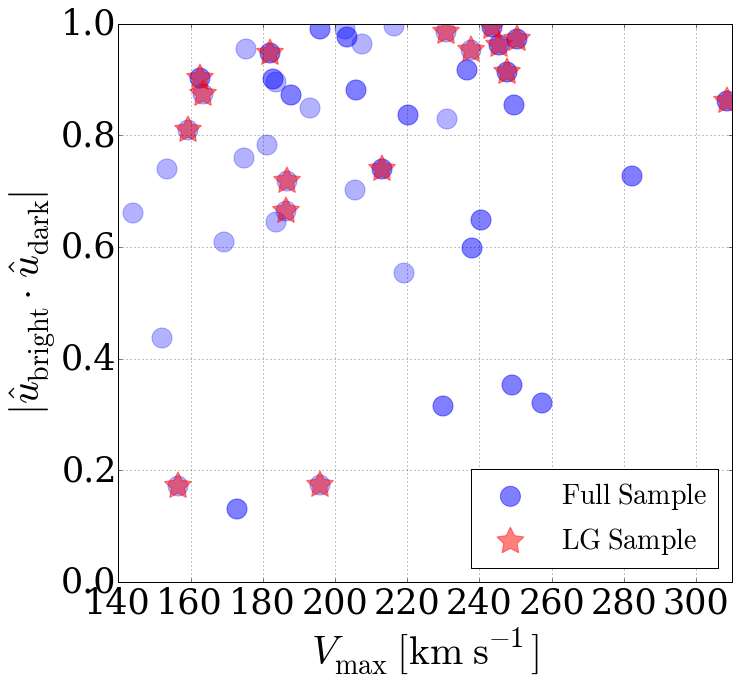

In [43]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(v_circ_A[ifull], dot_product_shape_A[ifull],
                label='$\mathrm{Full\ Sample}$',s=400,alpha=0.5,color='b')
plt.scatter(v_circ_B[ifull], dot_product_shape_B[ifull],s=400,alpha=0.3,color='b')

plt.scatter(v_circ_A[lgsample], dot_product_shape_A[lgsample],
                label='$\mathrm{LG\ Sample}$',s=800,alpha=0.5,color='red', marker=(5,1))
plt.scatter(v_circ_B[lgsample], dot_product_shape_B[lgsample],s=800,alpha=0.5,color='red', marker=(5,1))

#plt.scatter(n_bright_A[ifull], plane_width_bright_A[ifull],
#                label='$\mathrm{Full\ Sample\ (Bright)}$',s=400,alpha=0.5,color='red', marker=(5,1))
#plt.scatter(n_bright_B[ifull], plane_width_bright_B[ifull],s=400,alpha=0.5,color='red',marker=(5,1))

#hubble = 0.73
#plt.scatter([n_MW, n_M31], [MW_plane_delta*hubble, M31_plane_delta*hubble],
#            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            

ax.set_xlim([140,310])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.ylabel(r'$|\hat{u}_{\rm{bright}}\cdot\ \hat{u}_{\rm{dark}}|$', size=40)
plt.xlabel(r'$V_{\rm{max}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/shape_align_n_dark.pdf', bbox_inches='tight')

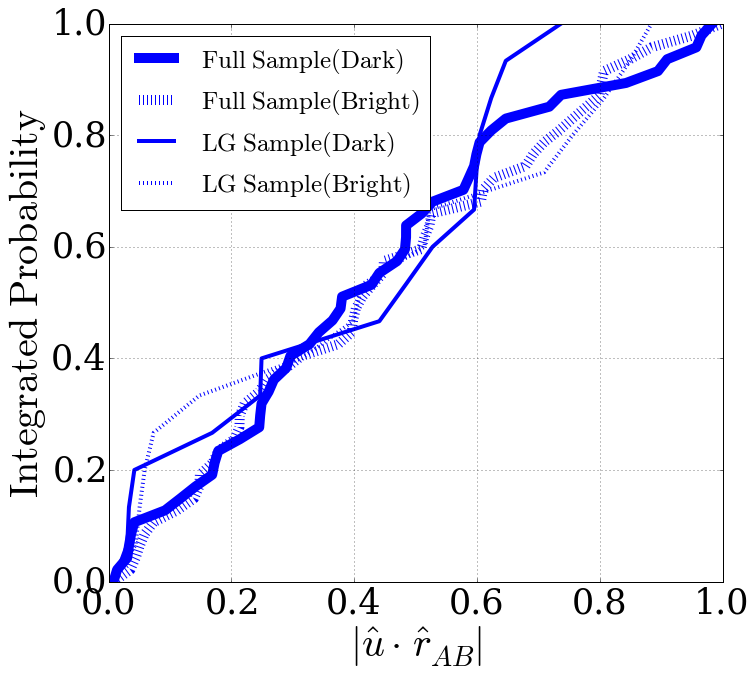

In [44]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


y = np.concatenate((dot_product_r_dark_A[ifull], dot_product_r_dark_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((dot_product_r_bright_A[ifull], dot_product_r_bright_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')

y = np.concatenate((dot_product_r_dark_A[lgsample], dot_product_r_dark_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')

y = np.concatenate((dot_product_r_bright_A[lgsample], dot_product_r_bright_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Bright)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/r_u_alignment_integrated.pdf', bbox_inches='tight')

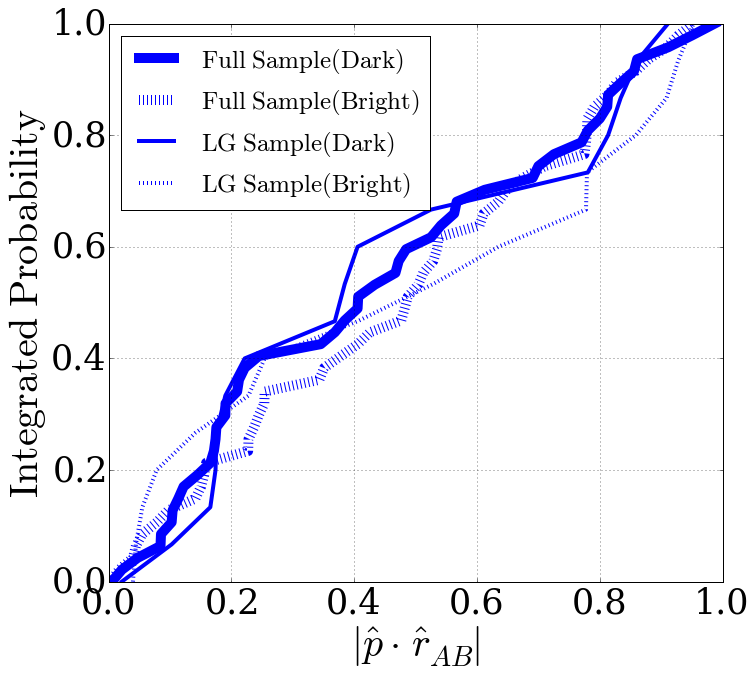

In [45]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

y = np.concatenate((dot_product_plane_dark_A[ifull], dot_product_plane_dark_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((dot_product_plane_bright_A[ifull], dot_product_plane_bright_B[ifull]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')

y = np.concatenate((dot_product_plane_dark_A[lgsample], dot_product_plane_dark_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Dark)}$',color='b', linewidth=4, linestyle='-')

y = np.concatenate((dot_product_plane_bright_A[lgsample], dot_product_plane_bright_B[lgsample]), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{LG\ Sample (Bright)}$',color='b', linewidth=4, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{p}\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/p_u_alignment_integrated.pdf', bbox_inches='tight')

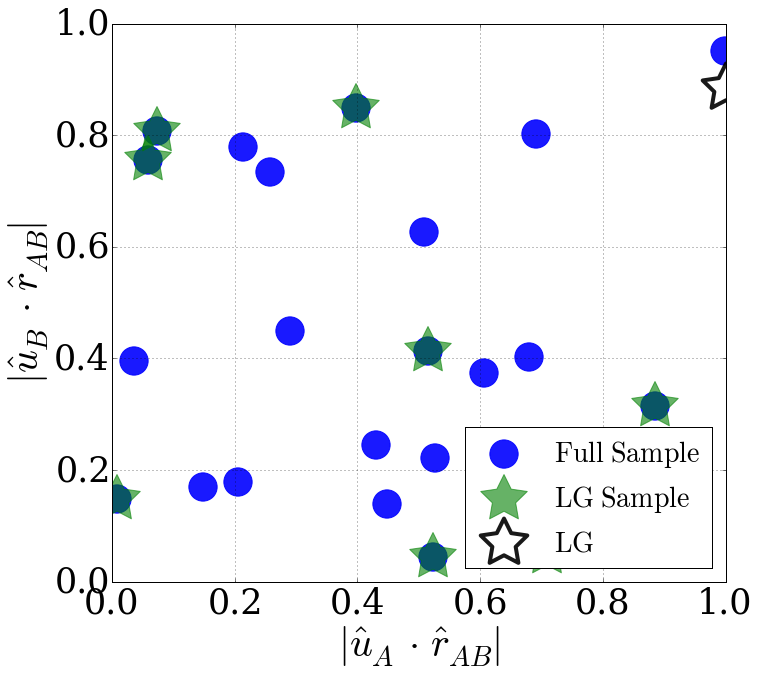

In [46]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(dot_product_r_bright_A[ifull], dot_product_r_bright_B[ifull],
                label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(dot_product_r_bright_A[lgsample], dot_product_r_bright_B[lgsample],
                label='$\mathrm{LG\ Sample}$',s=2400,alpha=0.6,color='green', marker=(5,1))

hubble = 0.73
plt.scatter(dot_product_r_M31, dot_product_r_MW,
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)

#a = plt.errorbar(M31_dot_product[1], MW_dot_product[1], 
#                 xerr=[[M31_dot_product[1]-M31_dot_product[0]],[M31_dot_product[2]-M31_dot_product[1]]],
#                 yerr=[[MW_dot_product[1]-MW_dot_product[0]],[MW_dot_product[2]-MW_dot_product[1]]])

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}_A\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'$|\hat{u}_B\cdot\ \hat{r}_{AB}|$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/r_u_alignment.pdf', bbox_inches='tight')

In [ ]:
ab_full, ax_full, bx_full = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_bright_A[ifull]), \
                                    list_N_points_B=np.int_(n_bright_B[ifull]))
ab_lgsample, ax_lgsample, bx_lgsample = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_bright_A[lgsample]), \
                                    list_N_points_B=np.int_(n_bright_B[lgsample]))

In [ ]:
ab_full_dark, ax_full_dark, bx_full_dark = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_dark_A[ifull]), \
                                    list_N_points_B=np.int_(n_dark_B[ifull]))
ab_lgsample_dark, ax_lgsample_dark, bx_lgsample_dark = monte_carlo_sample_pairs(n_monte_carlo=20000, \
                                    list_N_points_A=np.int_(n_dark_A[lgsample]), \
                                    list_N_points_B=np.int_(n_dark_B[lgsample]))

In [ ]:
def plot_significance(ax_data, bx_data, dot_a_data_list, dot_b_data_list, index_data, name='full_bright', 
                      label_list=r'$a$', color_list='black', axis_x='a', axis_y='b'):
    pfig = plt.figure(1, figsize=(11,10))
    ax = plt.axes()
    set_ticklabels(ax, size=35)

    args = {"linewidths": 4}

    cont = density_contour(ax_data, bx_data, 15, 15, **args)
    fmt = {}
    strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    for l, s in zip(cont.levels, strs):
        fmt[l] = s
    labels = plt.clabel(cont, inline=1, fontsize=40, fmt=fmt)
    for l in labels:
        l.set_rotation(0)

    for dot_a_data, dot_b_data, label,c in zip(dot_a_data_list, dot_b_data_list, label_list, color_list):
        mu_A = dot_a_data[index_data]
        mu_B = dot_b_data[index_data]
        plt.scatter(np.median(mu_A), np.median(mu_B),
                    s=2400,c='black', marker=(5,1), label=label, facecolor=c, linewidth=3)
    
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    ax.grid(True)
    plt.xlabel(axis_x, size=40)
    plt.ylabel(axis_y, size=40)
    plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
    plt.savefig('../paper/significance_{}.pdf'.format(name), bbox_inches='tight')

In [ ]:
plot_significance(ax_full, bx_full, [dot_product_r_dark_A, dot_product_r_bright_A], 
                  [dot_product_r_dark_A, dot_product_r_bright_B], 
                  ifull, name='full_bright', color_list=['black', 'white'],
                  label_list=[r'$\rm{Full\ Sample\ (dark)}$', r'$\rm{Full\ Sample\ (bright)}$'],
                  axis_x=r'${\rm median}\ |\hat{u}_A\cdot\ \hat{r}_{AB}|$', 
                  axis_y=r'${\rm median}\ |\hat{u}_B\cdot\ \hat{r}_{AB}|$')

In [ ]:
plot_significance(ax_lgsample, bx_lgsample, [dot_product_r_dark_A, dot_product_r_bright_A], 
                  [dot_product_r_dark_A, dot_product_r_bright_B], 
                  lgsample, name='lg_bright', color_list=['black', 'white'],
                  label_list=[r'$\rm{LG\ Sample\ (dark)}$', r'$\rm{LG\ Sample\ (bright)}$'],
                  axis_x=r'${\rm median}\ |\hat{u}_A\cdot\ \hat{r}_{AB}|$', 
                  axis_y=r'${\rm median}\ |\hat{u}_B\cdot\ \hat{r}_{AB}|$')

In [ ]:
plot_significance(ax_lgsample, bx_lgsample, [dot_product_shape_A], 
                  [dot_product_shape_B], 
                  lgsample, name='internal_lg_bright', color_list=['black'],
                  label_list=[r'$\rm{LG\ Sample}$'],
                  axis_x=r'${\rm median}\ |\hat{u}_{\rm{bright,A}}\cdot\ \hat{u}_{\rm{dark,A}}|$', 
                  axis_y=r'${\rm median}\ |\hat{u}_{\rm{bright,B}}\cdot\ \hat{u}_{\rm{dark,B}}|$')

In [ ]:
plot_significance(ax_full, bx_full, [dot_product_shape_A], 
                  [dot_product_shape_B], 
                  ifull, name='internal_full_bright', color_list=['black'],
                  label_list=[r'$\rm{Full\ Sample}$'],
                  axis_x=r'${\rm median}\ |\hat{u}_{\rm{bright,A}}\cdot\ \hat{u}_{\rm{dark,A}}|$', 
                  axis_y=r'${\rm median}\ |\hat{u}_{\rm{bright,B}}\cdot\ \hat{u}_{\rm{dark,B}}|$')

In [ ]:
a=plt.hist(ab_lgsample_dark)
print ab_full_dark.std()
print ab_lgsample_dark.std()
print dot_product_bright_AB[ifull].mean()
print dot_product_bright_AB[lgsample].mean()
print np.abs(np.dot(vectors_MW[0], vectors_M31[0]))